In [5]:
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("../data/datasets/abs_60topics_filt_jul.pkl")
import glob

In [6]:
%load_ext autoreload
%autoreload 1
%load_ext rpy2.ipython

In [7]:
from base.tools import RGBToHTMLColor
from base.plotting import nine_colors
nine_colors_hex = [RGBToHTMLColor(color) for color in nine_colors]
%Rpush nine_colors_hex

In [8]:
import numpy as np
from base.classifiers import OnevsallContinuous
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from base import tools

In [9]:
from sklearn.metrics import roc_auc_score
%aimport base.mv

In [10]:
zones = {3 : 'Posterior', 6 : 'Posterior', 9 : 'Middle', 5: 'Middle', 1 : 'Middle', 7: 'Middle', 2: 'Anterior', 4: 'Anterior', 8 : 'Anterior'}
zones = {key-1 : zones[key] for key in zones}

## Lasso Lars

In [11]:
lclf = OnevsallContinuous.load('../results/newmFC_kmeans_coact_m100_pca_9_LassoLarsIC_t0.05_cog_topics_60/classifier.pkl')

In [12]:
n_boot = 1000
pb = tools.ProgressBar(n_boot * lclf.data.shape[0], start=True)

In [13]:
bs_lasso_results = []
for reg, (X, y) in enumerate(lclf.data):
    for i in range(n_boot):

        ran_index = np.random.choice(X.shape[0], X.shape[0])

        # Bootstrap sample X & y
        newX = X[ran_index, :]
        newy = y[ran_index]
        
        fit_clf = lclf.classifier.fit(newX, newy)

        alpha = fit_clf.alpha_
        n_non_zero = np.nonzero(fit_clf.coef_)[0].shape
        bs_lasso_results.append([reg, i, alpha, n_non_zero[0]])
        pb.next()

KeyboardInterrupt: 

In [ ]:
bs_lasso_results = pd.DataFrame(bs_lasso_results, columns=['region', 'n_boot', 'alpha', 'n_nonzero'])

In [ ]:
%Rpush bs_lasso_results

In [ ]:
la_ninetyfive_ci_alpha = bs_lasso_results.groupby(['region']).apply(lambda x: pd.Series(np.percentile(x.alpha, [2.5, 50, 97.5]))).rename(columns={0:'lower', 1:'mean', 2: 'upper'}).reset_index()
la_ninetyfive_ci_n_nonzero = bs_lasso_results.groupby(['region']).apply(lambda x: pd.Series(np.percentile(x.n_nonzero, [2.5, 50, 97.5]))).rename(columns={0:'lower', 1:'mean', 2: 'upper'}).reset_index()
la_ninetyfive_ci_n_nonzero['zone']  = la_ninetyfive_ci_n_nonzero.region.map(zones)
la_ninetyfive_ci_alpha['zone']  = la_ninetyfive_ci_alpha.region.map(zones)

%Rpush la_ninetyfive_ci_alpha la_ninetyfive_ci_n_nonzero

In [ ]:
%%R -w 600 -h 500
ggplot(la_ninetyfive_ci_alpha, aes(zone, mean, fill=factor(region), group=factor(region), ymin=lower, ymax=upper)) + 
geom_bar(stat='identity', position='dodge') + 
scale_color_manual(values= nine_colors_hex) + 
scale_fill_manual(values= nine_colors_hex) + 

theme_bw() + theme(legend.position ="none") +
# coord_cartesian(ylim=c(3.18, 3.45)) + 
geom_errorbar(stat="identity", position=position_dodge(width=0.9), width=0.2)

In [ ]:
%%R -w 600 -h 500
ggplot(la_ninetyfive_ci_n_nonzero, aes(zone, mean, fill=factor(region), group=factor(region), ymin=lower, ymax=upper)) + 
geom_bar(stat='identity', position='dodge') + 
scale_color_manual(values= nine_colors_hex) + 
scale_fill_manual(values= nine_colors_hex) + 

theme_bw() + theme(legend.position ="none") +
coord_cartesian(ylim=c(18, 35)) + 
geom_errorbar(stat="identity", position=position_dodge(width=0.9), width=0.2)

## Shannons

In [ ]:
results = base.mv.bootstrap_mv(clf, roc_auc_score, processes=8, boot_n = 1000, method='shannons')

In [ ]:
si_ninetyfive_ci = results.groupby(['region']).apply(lambda x: pd.Series(np.percentile(x.shannons, [2.5, 50, 97.5]))).rename(columns={0:'lower', 1:'mean', 2: 'upper'}).reset_index()

In [ ]:
si_ninetyfive_ci['zone']  = si_ninetyfive_ci.region.map(zones)


In [ ]:
%Rpush si_ninetyfive_ci

In [ ]:
si_ninetyfive_ci

In [ ]:
%%R -w 600 -h 500
ggplot(si_ninetyfive_ci, aes(zone, mean, fill=factor(region), group=factor(region), ymin=lower, ymax=upper)) + 
geom_bar(stat='identity', position='dodge') + 
scale_color_manual(values= nine_colors_hex) + 
scale_fill_manual(values= nine_colors_hex) + 

theme_bw() + theme(legend.position ="none") +
coord_cartesian(ylim=c(3.18, 3.45)) + 
geom_errorbar(stat="identity", position=position_dodge(width=0.9), width=0.2)


In [ ]:
si_ninetyfive_ci['mean']

In [ ]:
tools.make_mask_map(si_ninetyfive_ci['mean'], clf.mask_img, '../results/newmFC_kmeans_coact_m100_pca_9_GNB_t0.05_cog_topics_' + str(n_regions) + '/sdi')

## Full boostrapped combinatorial

In [ ]:
results = [pd.read_csv(file) for file in glob.glob('../results/perm_complexity/boot*full*60*')]
for i, df in enumerate(results):
    df['i'] = i
results = pd.concat(results)

In [ ]:
results['boot_id'] = results.boot_n.astype('string') + results.i.astype('string')

In [ ]:
perm_max = results.groupby(['region', 'boot_id']).apply(lambda x : x[x.score == x.score.max()][['num_features', 'score']])

In [ ]:
z_n_feat = pd.DataFrame(perm_max.reset_index().groupby(['boot_id']).apply(lambda x: (x.num_features - x.num_features.mean()) / x.num_features.std()))

In [ ]:
z_n_feat['region'] = perm_max.reset_index().groupby(['boot_id']).apply(lambda x: x.region)

In [ ]:
n_feat_95ci_z = z_n_feat.groupby(['region']).apply(lambda x: pd.Series(np.percentile(x.num_features, [2.5, 50, 97.5]))).rename(columns={0:'lower', 1:'mean', 2: 'upper'}).reset_index()
n_feat_95ci_z['zone']  = n_feat_95ci_z.region.map(zones)

In [ ]:
%Rpush n_feat_95ci_z

In [ ]:
%%R -w 600 -h 500
ggplot(n_feat_95ci_z, aes(zone, mean, fill=factor(region), group=factor(region), ymin=lower, ymax=upper)) + 
geom_bar(stat='identity', position='dodge') + 
scale_color_manual(values= nine_colors_hex) + 
scale_fill_manual(values= nine_colors_hex) + 

theme_bw() + theme(legend.position ="none") +
# coord_cartesian(ylim=c(, 30)) + 
geom_errorbar(stat="identity", position=position_dodge(width=0.9), width=0.2)

### Rank

In [ ]:
perm_max.reset_index().groupby('boot_id').rank().num_features

In [ ]:
rank_n = perm_max.reset_index()

In [ ]:
rank_n['n_features_r'] = rank_n.groupby('boot_id').rank().num_features

In [ ]:
rank_n_95 = rank_n.groupby(['region']).apply(lambda x: pd.Series(np.percentile(x.n_features_r, [2.5, 50, 97.5]))).rename(columns={0:'lower', 1:'mean', 2: 'upper'}).reset_index()
rank_n_95['zone']  = rank_n_95.region.map(zones)

%Rpush rank_n_95

In [ ]:
%%R -w 600 -h 500
ggplot(rank_n_95, aes(zone, mean, fill=factor(region), group=factor(region), ymin=lower, ymax=upper)) + 
geom_bar(stat='identity', position='dodge') + 
scale_color_manual(values= nine_colors_hex) + 
scale_fill_manual(values= nine_colors_hex) + 

theme_bw() + theme(legend.position ="none") +
# coord_cartesian(ylim=c(, 30)) + 
geom_errorbar(stat="identity", position=position_dodge(width=0.9), width=0.2)

## Combinatorial selection

In [14]:
results = [pd.read_csv(file) for file in glob.glob('../results/perm_complexity/boot*60*')]
for i, df in enumerate(results):
    df['i'] = i
results = pd.concat(results)

In [15]:
perm_max = results.groupby(['region', 'boot_n', 'i']).apply(lambda x : x[x.score == x.score.max()][['num_features', 'score']])

In [16]:
reg_avg_max = results.groupby(['region', 'num_features']).mean()[['score']].reset_index().groupby('region').apply(lambda x: x[x.score == x.score.max()])[['num_features', 'score']].reset_index()

In [17]:
region_max = pd.DataFrame(perm_max).reset_index().groupby('region').mean().reset_index()

In [18]:
from base import tools

In [49]:
reg_avg_max.num_features.max()

28

In [19]:
tools.make_mask_map((reg_avg_max.num_features / 100) - ((reg_avg_max.num_features / 100).min() + 0.0001),'../results/perm_cluster/medial_fc_30_kmeans/kmeans_k9/cluster_labels.nii.gz', '../results/newmFC_kmeans_coact_m100_pca_9_GNB_t0.05_cog_topics_' + str(60) + '/boot_nfeatures_1000')

In [20]:
reg_avg_max.min()

region           0.000000
level_1         22.000000
num_features    19.000000
score            0.595788
dtype: float64

In [ ]:
n_

In [21]:

near_max = results.groupby(['region', 'boot_n', 'i']).apply(minimum_percent).rename(columns={0:'num_features', 1:'score'}).reset_index().groupby('region').mean().reset_index()
tools.make_mask_map(near_max.num_features / 100, clf.mask_img, '../results/newmFC_kmeans_coact_m100_pca_9_GNB_t0.05_cog_topics_' + str(n_regions) + '/boot_nfeatures_near_max_1000')

NameError: name 'minimum_percent' is not defined

In [22]:
ninetyfive_ci = results.groupby(['region', 'num_features']).apply(lambda x: pd.Series(np.percentile(x.score, [2.5, 97.5]))).rename(columns={0:'lower', 1:'upper'}).reset_index()

In [23]:
results['zone']  = results.region.map(zones)
reg_avg_max['zone']  = reg_avg_max.region.map(zones)
ninetyfive_ci['zone']  = ninetyfive_ci.region.map(zones)

In [24]:
results.region.max()

8

In [25]:
n_feat_95ci = results.groupby(['region', 'boot_n', 'i']).apply(minimum_percent).rename(columns={0:'num_features', 1:'score'})[['score', 'num_features']].reset_index().groupby('region').apply(lambda x: pd.Series(np.percentile(x.num_features, [2.5, 50, 97.5]))).rename(columns={0:'lower', 1:'mean', 2: 'upper'}).reset_index()
n_feat_95ci['zone']  = n_feat_95ci.region.map(zones)
%Rpush n_feat_95ci

NameError: name 'minimum_percent' is not defined

In [26]:
%Rpush results region_max reg_avg_max ninetyfive_ci 

In [31]:
%%R -w 600 -h 500
ggplot(n_feat_95ci, aes(zone, mean, fill=factor(region), group=factor(region), ymin=lower, ymax=upper)) + 
geom_bar(stat='identity', position='dodge') + 
scale_color_manual(values= nine_colors_hex) + 
scale_fill_manual(values= nine_colors_hex) + 

theme_bw() + theme(legend.position ="none") +
# coord_cartesian(ylim=c(, 30)) + 
geom_errorbar(stat="identity", position=position_dodge(width=0.9), width=0.2)



Error in ggplot(n_feat_95ci, aes(zone, mean, fill = factor(region), group = factor(region),  : 
  object 'n_feat_95ci' not found


/Users/aleph4/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in ggplot(n_feat_95ci, aes(zone, mean, fill = factor(region), group = factor(region),  : 
  object 'n_feat_95ci' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [42]:
results

,Unnamed: 0,score,num_features,feature,region,boot_n,i,zone
0,0,0.526960,0,topic59,0,0,0,Middle
1,1,0.551711,1,topic50,0,0,0,Middle
2,2,0.562808,2,topic44,0,0,0,Middle
3,3,0.569711,3,topic15,0,0,0,Middle
4,4,0.575953,4,topic39,0,0,0,Middle
5,5,0.581371,5,topic48,0,0,0,Middle
6,6,0.586919,6,topic29,0,0,0,Middle
7,7,0.588796,7,topic53,0,0,0,Middle
8,8,0.590484,8,topic19,0,0,0,Middle
9,9,0.591793,9,topic20,0,0,0,Middle


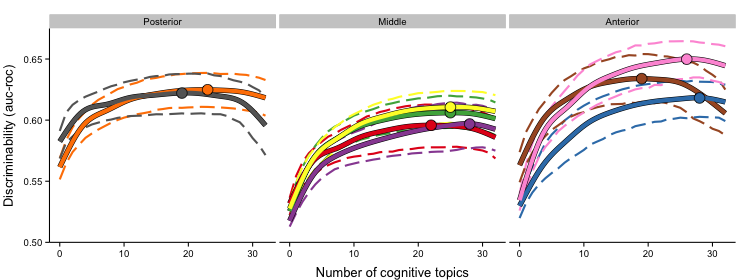

In [33]:
%%R -w 750 -h 280
library(ggplot2)
results$zone <- factor(results$zone, levels=rev(levels(results$zone)))
ggplot(results, aes(num_features, score,group=region, color=factor(region))) + 
# geom_line(aes(group=boot_n), size=.5, alpha=0.05) +

geom_line(data=ninetyfive_ci, aes(num_features, upper, group=factor(region), color=factor(region)), linetype=5, size=1) + 
geom_line(data=ninetyfive_ci, aes(num_features, lower, group=factor(region), color=factor(region)), linetype=5, size=1) + 
geom_line(stat='smooth', size=2.5, color='black', span=.12) +
geom_line(stat='smooth', size=2, span=.12) +
geom_point(data=reg_avg_max, aes(num_features, score, group=1, fill=factor(region)), shape=21, size = 5, color='black')+

theme_bw() + ylab("Discriminability (auc-roc)" ) + xlab("Number of cognitive topics") + 
theme(axis.title.y = element_text(size = 13, vjust = 1.5), axis.title.x= element_text(size = 13, vjust = -.5)) + coord_cartesian(ylim=c(0.5, 0.675)) +
scale_color_manual(values= nine_colors_hex)+
scale_fill_manual(values= nine_colors_hex)+
scale_alpha(range=c(0,1)) +
facet_grid(.~zone) + 
theme(panel.border = element_blank(), panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"), legend.title=element_blank(),
     legend.position ="none") 

# ggsave('../reports/papers/mFC/complexity_by_zone.png')

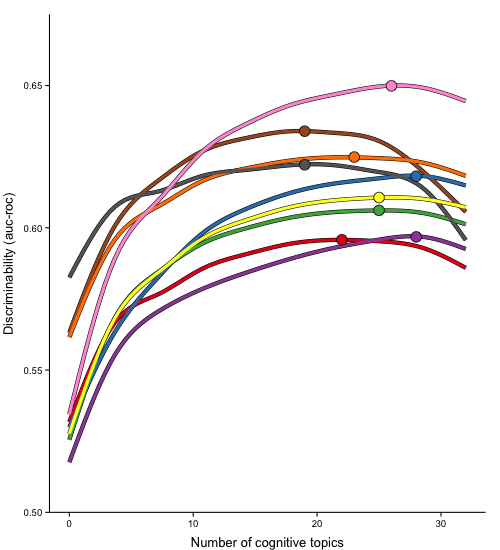

In [29]:
%%R -w 500 -h 550
library(ggplot2)
ggplot(results, aes(num_features, score,group=region, color=factor(region))) + 
# geom_line(aes(group=boot_n), size=.5, alpha=0.05) +
geom_line(stat='smooth', size=2, color='black', span=.12) +
geom_line(stat='smooth', size=1.5, span=.12) +
geom_point(data=reg_avg_max, aes(num_features, score, group=1, fill=factor(region)), shape=21, size = 5, color='black')+
# geom_line(data=ninetyfive_ci, aes(num_features, upper, group=factor(region), color=factor(region)), linetype=2, size=1) + 
# geom_line(data=ninetyfive_ci, aes(num_features, lower, group=factor(region), color=factor(region)), linetype=2, size=1) + 
theme_bw() + ylab("Discriminability (auc-roc)" ) + xlab("Number of cognitive topics") + 
theme(axis.title.y = element_text(size = 13, vjust = 1.5), axis.title.x= element_text(size = 13, vjust = -.5)) + coord_cartesian(ylim=c(0.5, 0.675)) +
scale_color_manual(values= nine_colors_hex)+
scale_fill_manual(values= nine_colors_hex)+
scale_alpha(range=c(0,1)) +
# facet_grid(zone~.) + 
theme(panel.border = element_blank(), panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"), legend.title=element_blank(),
     legend.position ="none") 

In [30]:
tools.make_mask_map(reg_avg_max.score, clf.mask_img, '../results/newmFC_kmeans_coact_m100_pca_9_GNB_t0.05_cog_topics_' + str(n_regions) + '/boot_max_score')

NameError: name 'clf' is not defined

In [ ]:
reg_avg_max

In [ ]:
from scipy import stats

In [51]:
clf = OnevsallContinuous.load('../results/newmFC_kmeans_coact_m100_pca_9_GNB_t0.05_cog_topics_60/classifier.pkl')

In [ ]:
stats.pearsonr(reg_avg_max.num_features, reg_avg_max.score)

In [52]:
base_rates = tools.region_vox_baserates(dataset, clf.mask_img)

WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


In [53]:
mean_br = base_rates.groupby('region').mean()

In [57]:
from scipy import stats

In [58]:
stats.pearsonr(mean_br.base_rate, reg_avg_max.score)

(-0.39142171938252335, 0.29752145707079081)

In [59]:
stats.pearsonr(mean_br.base_rate, reg_avg_max.num_features)

(0.24344077152098659, 0.52791025193458818)

In [ ]:
from neurosynth.base import imageutils

In [ ]:
images = imageutils.load_imgs(clf.mask_img, dataset.masker)

In [ ]:
images = np.round(images).astype('int')

In [ ]:
sizes = np.bincount(images.squeeze())[1:10]

In [ ]:
stats.pearsonr(sizes, reg_avg_max.num_features)

In [ ]:
stats.pearsonr(sizes, reg_avg_max.score)

In [38]:
from nilearn import plotting as niplt

In [35]:
C = [255,255,255;
255,255,254;
255,255,253;
255,255,252;
255,255,251;
255,255,250;
255,255,249;
255,255,248;
255,255,247;
255,255,246;
255,255,246;
255,255,245;
255,255,244;
255,255,243;
255,255,242;
255,255,241;
255,255,240;
255,255,239;
255,255,238;
255,255,237;
255,255,236;
255,255,235;
255,255,234;
255,255,233;
255,255,232;
255,255,231;
255,255,230;
255,255,229;
255,255,229;
255,255,228;
255,255,227;
255,255,226;
255,255,225;
255,255,224;
255,255,223;
255,255,222;
255,255,221;
255,255,220;
255,255,219;
255,255,218;
255,255,217;
255,255,216;
255,255,215;
255,255,214;
255,255,213;
255,255,212;
255,255,212;
255,255,211;
255,255,210;
255,255,209;
255,255,208;
255,255,207;
255,255,206;
255,255,205;
255,255,204;
255,255,203;
255,255,202;
255,255,201;
255,255,200;
255,255,199;
255,255,198;
255,255,197;
255,255,196;
255,255,195;
255,255,194;
255,254,191;
255,253,188;
255,252,185;
255,250,182;
255,249,179;
255,248,176;
255,247,173;
255,246,170;
255,245,166;
255,244,163;
255,243,160;
255,242,157;
255,241,154;
255,240,151;
255,239,148;
255,238,145;
255,237,142;
255,236,139;
255,234,136;
255,233,133;
255,232,130;
255,231,127;
255,230,124;
255,229,121;
255,228,118;
255,227,115;
255,226,111;
255,225,108;
255,224,105;
255,223,102;
255,222,99;
255,221,96;
255,220,93;
255,218,90;
255,217,87;
255,216,84;
255,215,81;
255,214,78;
255,213,75;
255,212,72;
255,211,69;
255,210,66;
255,209,63;
255,208,60;
255,207,57;
255,206,53;
255,205,50;
255,204,47;
255,202,44;
255,201,41;
255,200,38;
255,199,35;
255,198,32;
255,197,29;
255,196,26;
255,195,23;
255,194,20;
255,193,17;
255,192,14;
255,191,11;
255,190,8;
255,189,5;
255,188,2;
255,186,0;
255,183,0;
255,180,0;
255,177,0;
255,174,0;
255,171,0;
255,168,0;
255,165,0;
255,162,0;
255,159,0;
255,156,0;
255,153,0;
255,150,0;
255,147,0;
255,144,0;
255,142,0;
255,139,0;
255,136,0;
255,133,0;
255,130,0;
255,127,0;
255,124,0;
255,121,0;
255,118,0;
255,115,0;
255,112,0;
255,109,0;
255,106,0;
255,103,0;
255,100,0;
255,98,0;
255,95,0;
255,92,0;
255,89,0;
255,86,0;
255,83,0;
255,80,0;
255,77,0;
255,74,0;
255,71,0;
255,68,0;
255,65,0;
255,62,0;
255,59,0;
255,56,0;
255,54,0;
255,51,0;
255,48,0;
255,45,0;
255,42,0;
255,39,0;
255,36,0;
255,33,0;
255,30,0;
255,27,0;
255,24,0;
255,21,0;
255,18,0;
255,15,0;
255,12,0;
255,10,0;
255,7,0;
255,4,0;
255,1,0;
253,0,0;
249,0,0;
245,0,0;
241,0,0;
237,0,0;
233,0,0;
229,0,0;
225,0,0;
221,0,0;
217,0,0;
213,0,0;
209,0,0;
205,0,0;
201,0,0;
197,0,0;
193,0,0;
189,0,0;
185,0,0;
181,0,0;
177,0,0;
173,0,0;
169,0,0;
164,0,0;
160,0,0;
156,0,0;
152,0,0;
148,0,0;
144,0,0;
140,0,0;
136,0,0;
132,0,0;
128,0,0;
124,0,0;
120,0,0;
116,0,0;
112,0,0;
108,0,0;
104,0,0;
100,0,0;
96,0,0;
92,0,0;
88,0,0;
84,0,0;
80,0,0;
76,0,0;
72,0,0;
68,0,0;
64,0,0;
60,0,0;
56,0,0;
52,0,0;
48,0,0;
44,0,0;
40,0,0;
36,0,0;
32,0,0;
28,0,0;
24,0,0;
20,0,0;
16,0,0;
12,0,0;
8,0,0;
4,0,0;
0,0,0]
import matplotlib as mpl # in python
cm = mpl.colors.ListedColormap(C/255)

SyntaxError: invalid syntax (<ipython-input-35-1964a69586c6>, line 1)

In [36]:
import matplotlib as mpl # in python


In [41]:
niplt.plot_stat_map('../results/newmFC_kmeans_coact_m100_pca_9_GNB_t0.05_cog_topics_60/boot_nfeatures_1000.nii',symmetric_cbar=False, display_mode='x', cut_coords=[0], cmap='summer', output_file='../reports/papers/mFC/complexity_9_brain.png')